(labs:cor5)=
# Mathematical morphology

<hr>

## 📌 Commentaires pour les intervenants

**Mathematical morphology**

* 📣 Rappeler aux étudiants que dans un premier temps, ils doivent mettre en place toute une chaîne de traitement
  qui fournisse un nombre de piscine, même approximatif, à partir de l'image.
  Il faut éviter qu'ils cherchent à parfaire chaque étape, car le risque est de ne pas réussir à développer une méthode complète,
  faute de temps.
  Par ailleurs, le fait de développer une méthode complète permet d'avoir suffisamment de recul
  pour définir quelle étape est la moins performante, et donc celle qu'il faut améliorer en premier.
  
* L'exercice est assez long. Si des étudiants le terminent, alors ils reviennent sur les TP précédents pour les terminer.

<hr>

### Objectives
* apply and compare basic operations (erosion, dilation, opening, closing)
* evaluate of the parameters of these operations
* use connected components to extract useful information

### First processings

In [1]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing, disk, label
from matplotlib.pyplot import imshow, figure, hist, show, subplot, title, plot
from numpy import arange

The image is a satellite view of a small town in the Landes, France. It is an RGB image of resolution 50 cm.

In [2]:
img = imread('moliets.png')

Since the objects of interest are blue and no other object in the scene is of this color,
it may be interesting to deal with the blue band of the image.
Therefore, the pools are bright on the blue band, giving first discrimination between the pools and the rest.

In [3]:
blue = img[:,:,2]

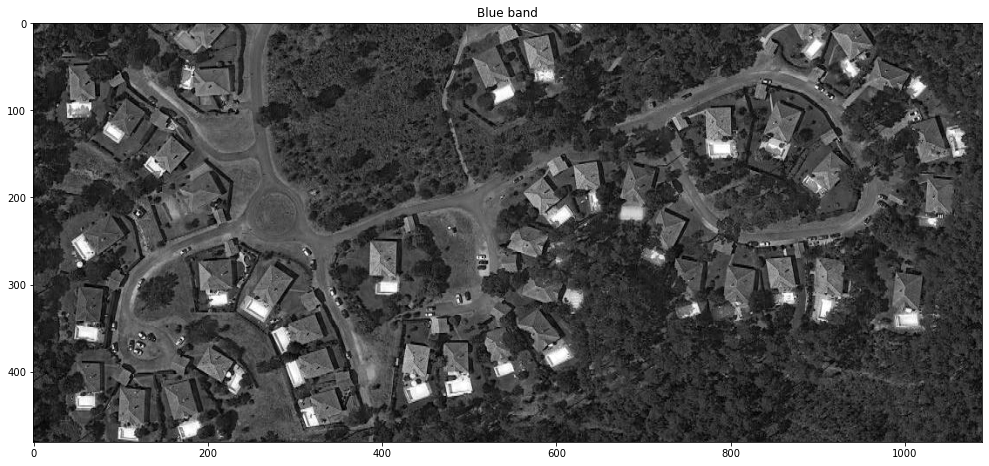

In [4]:
figure(figsize=(17,10))
imshow(blue, cmap='gray')
title('Blue band')
show()

The mathematical morphology operators described in the course work on binary images.
The blue band can be binarized by applying a threshold to separate the bright pixels from the others.
By looking at the histogram of the blue band and proceeding by trial and error,
we choose a threshold equals to 240.

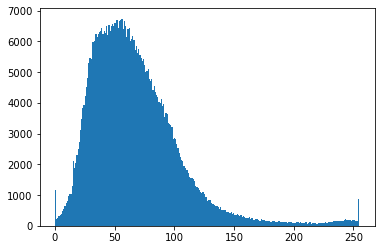

In [5]:
hist(blue.ravel(), bins=256)
show()

In [6]:
binarized = (blue > 240)

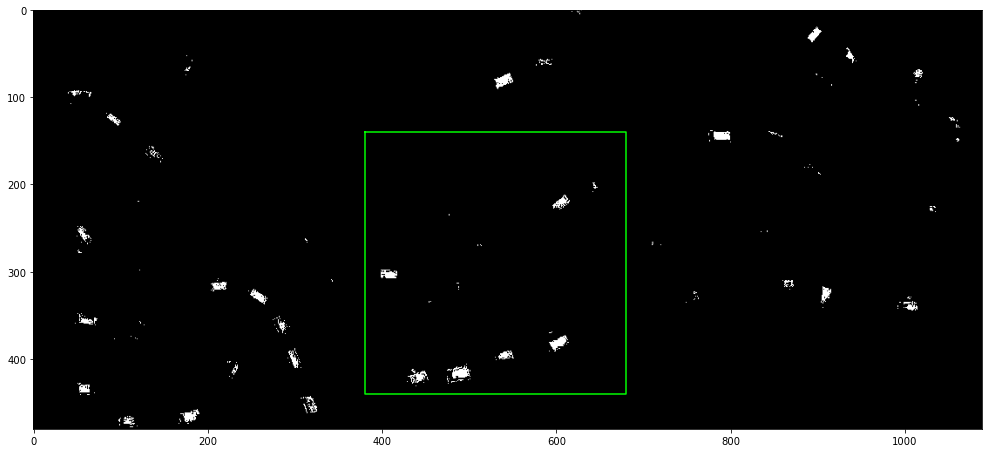

In [7]:
xmin, xmax, ymin, ymax = 380, 680, 140, 440
figure(figsize=(17,10))
imshow(binarized, cmap='gray')
plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color=[0,1,0])
show()

### Study of the different operators

In this part, the mathematical morphology operators are applied to the sub-image marked out by the green square on the image above.

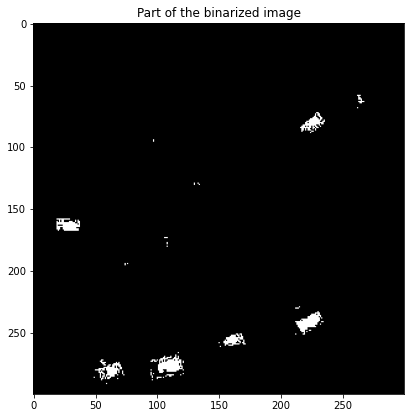

In [8]:
crop = binarized[ymin:ymax,xmin:xmax]
figure(figsize=(17,15))
subplot(2,2,1)
imshow(crop, cmap='gray')
title("Part of the binarized image")
show()

First of all, we choose as a structuring element a disk with a radius of 4 pixels.

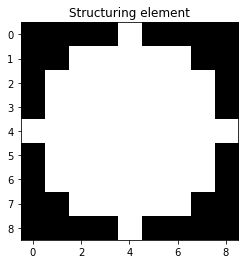

In [9]:
selem = disk(4)
imshow(selem, cmap='gray')
title("Structuring element")
show()

The four basic operators applied to the image produce the results below.

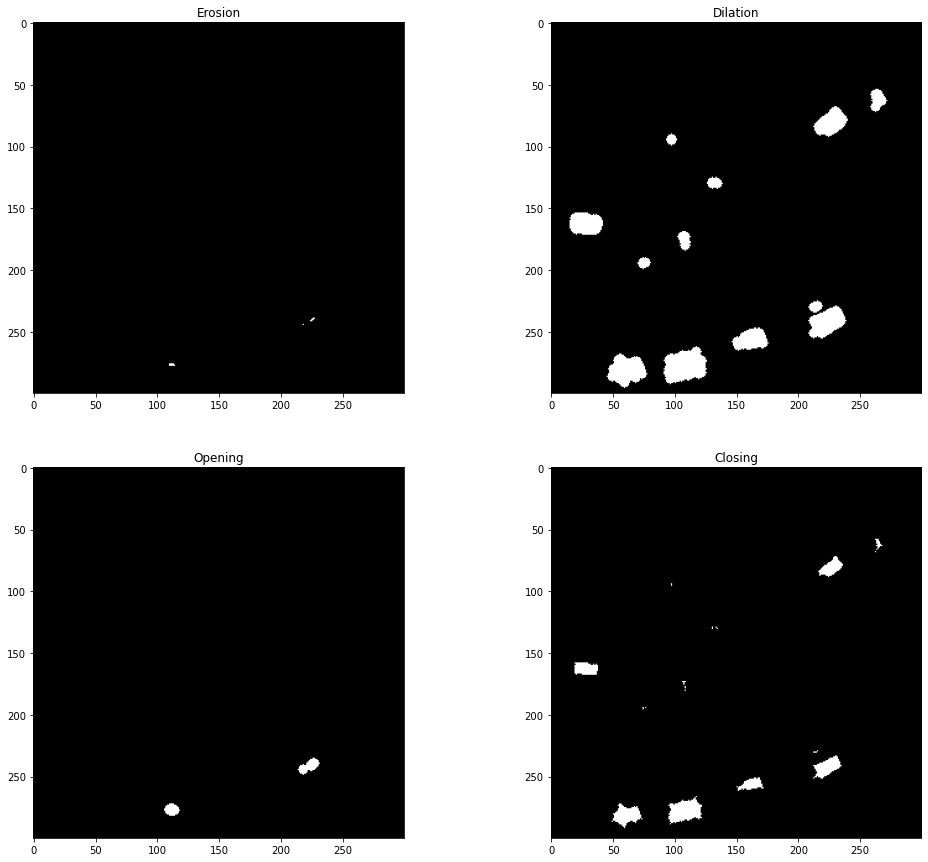

In [10]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Erosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Opening')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Closing')
show()

* Which operator(s) tend(s) to plug the holes?
* On the contrary, which operator(s) tend(s) to remove small objects?
* Which operator(s) preserve(s) (roughly) the shape of objects?

The same with a 10-pixel radius disk:

In [11]:
selem = disk(10)

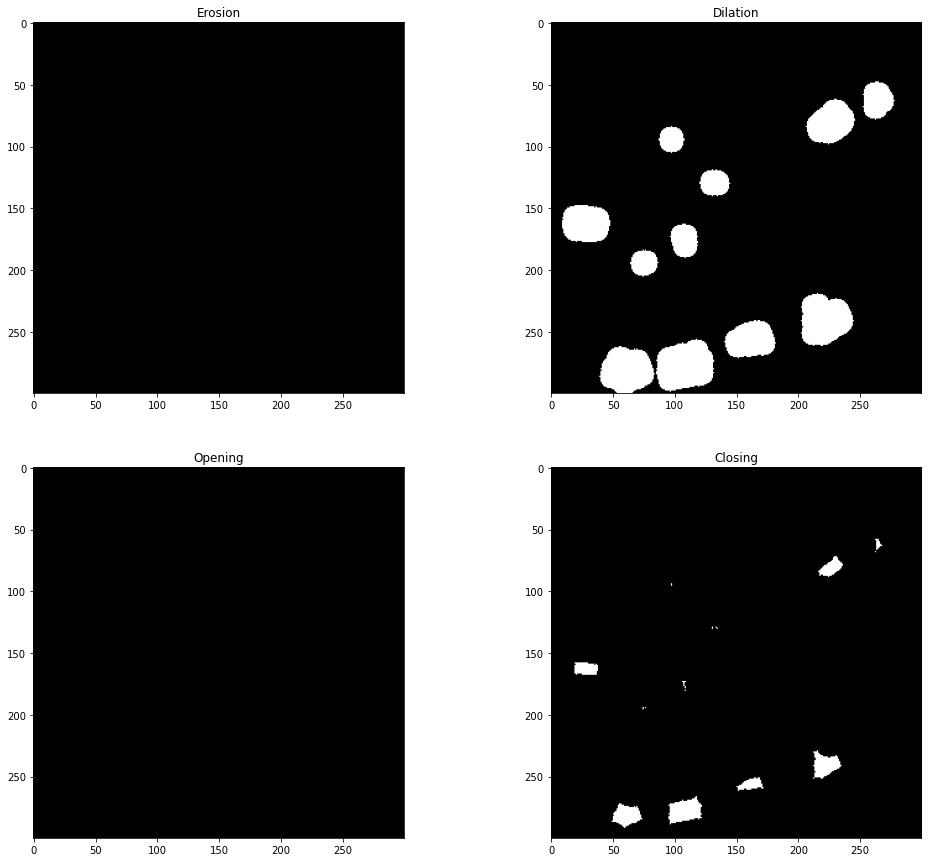

In [12]:
g_erosion = binary_erosion(crop, selem)
g_dilation = binary_dilation(crop, selem)
g_opening = binary_opening(crop, selem)
g_closing = binary_closing(crop, selem)

figure(figsize=(17,15))
subplot(2,2,1)
imshow(g_erosion, cmap='gray')
title('Erosion')
subplot(2,2,2)
imshow(g_dilation, cmap='gray')
title('Dilation')
subplot(2,2,3)
imshow(g_opening, cmap='gray')
title('Opening')
subplot(2,2,4)
imshow(g_closing, cmap='gray')
title('Closing')
show()

Try other structuring elements to observe their influence!

### Pool detection

In the following, we consider the result of a closing with a 10-pixel radius disk for structuring element.

The function `skimage.morphology.label` returns a labeling of the different connected components,
and the function `skimage.measure.regionprops` measure some geometric properties of the connected components,
such as their surface or their position.

In [13]:
# Élément structurant
selem = disk(10)

# Fermeture
img_closing = binary_closing(binarized, selem)

# Labellisation des composantes connexes
labels = label(img_closing, connectivity=2)

# Mesure des propriétés des composantes connexes
props = regionprops(labels)

# Nombre de composantes connexes
N = len(props)
print('Number of connected component (that is, detected pools): {}'.format(N))

Number of connected component (that is, detected pools): 69


The centroids of the connected components are represented in the image below by the red dots.

Of course, there are fewer pools than red dots, but a lot of connected components are actually
small groups of pixels that do not correspond to pools.

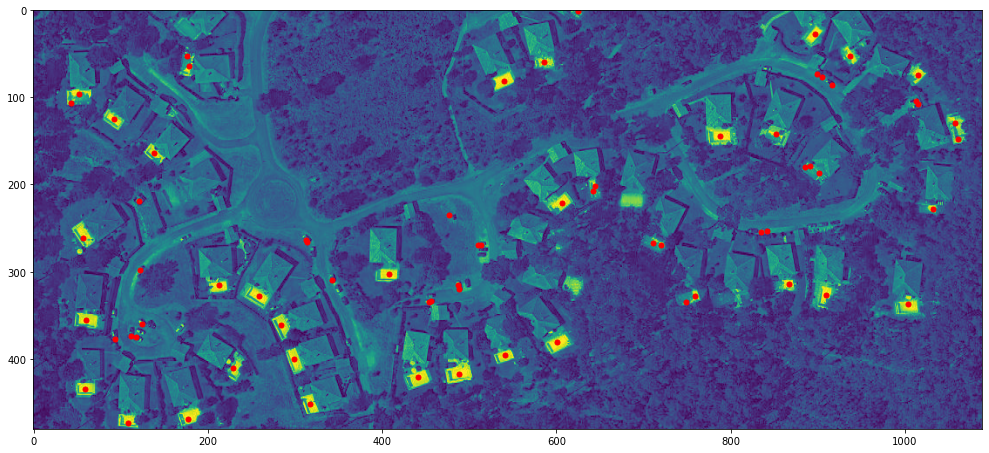

In [14]:
figure(figsize=(17,10))
imshow(blue)
for n in range(N):
    plot(props[n].centroid[1], props[n].centroid[0], 'r.', markersize=10)
show()


The result can be improved by considering only the connected components whose number of pixels is greater than a certain value.
So, we have chosen to consider as pools the connected components whose area is greater than 20 pixels.

Moreover, we know that a pixel represents an area of 0.5$\times$0.5 m<sup>2</sup>,
so it is easy to calculate the average area of the detected pools.

Number of detected pools: 36
Average area of the detected pools: 40.89 m²


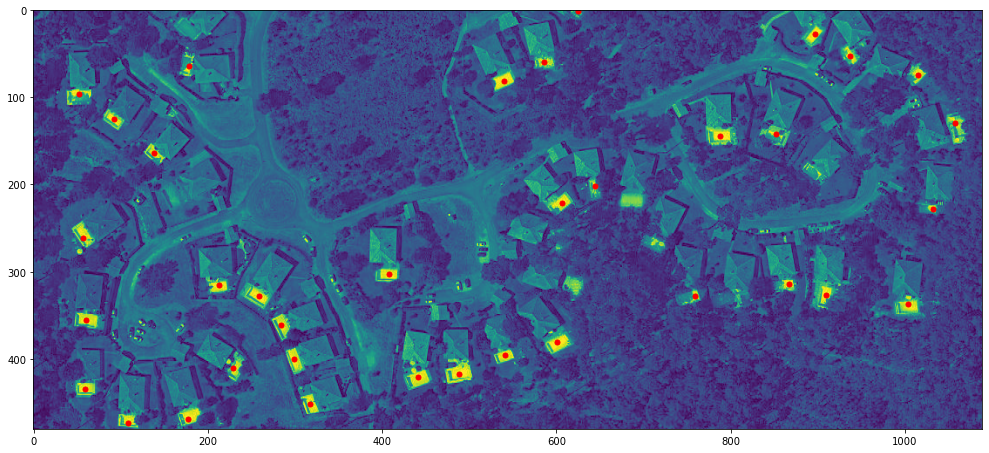

In [15]:
N = 0  # Nombre de piscines
A = 0  # Aire totale des piscines
figure(figsize=(17,10))
imshow(blue)
for r in props:
    if r.area > 20:
        N = N + 1
        A = A + r.area
        plot(r.centroid[1], r.centroid[0], 'r.', markersize=10)

print('Number of detected pools: {}'.format(N))
print('Average area of the detected pools: {:.2f} m²'.format(A/N*.5*.5))
show()

### Discussion

The method proposed in this notebook is simple but not robust: swimming pools shaded or partially hidden by a tree are not always detected. Conversely, some objects can be considered as swimming pools because they are very bright in the blue band and large.
Therefore, some improvements to improve the result are listed below:

* The geometry of the connected components can be considered because the swimming pools are not only blue objects with a sufficiently large area, but they also have a rectangular shape;
* we choose the threshold for binarization to work well on this image. But nothing guarantees that this value can be applied to another image: it may depend on the sensor resolution, the image brightness, the type of swimming pool, etc. In other words, the robustness of the threshold value has to be studied.
* the binarization of the image could take into account the binarization of the neighbouring pixels. This principle can be modelled using Markov fields.
* etc.